In [1]:
run cargar_shapefile.py

In [2]:
from osgeo import gdal
from CoordConv import ConvCordinates
from skimage.draw import polygon
from numpy.ma import masked_array

In [3]:
imgtif = gdal.Open("../MAPA_AEROVIAS_GEORECTIFICADO2.tif",
                   gdal.GA_ReadOnly)
imgtif.RasterCount
bands = list(map(lambda x: imgtif.GetRasterBand(x),
                 range(1, imgtif.RasterCount + 1)))
matrs = list(map(lambda x: x.ReadAsArray(), bands))

/home/dramon/anaconda3/envs/testgdal/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


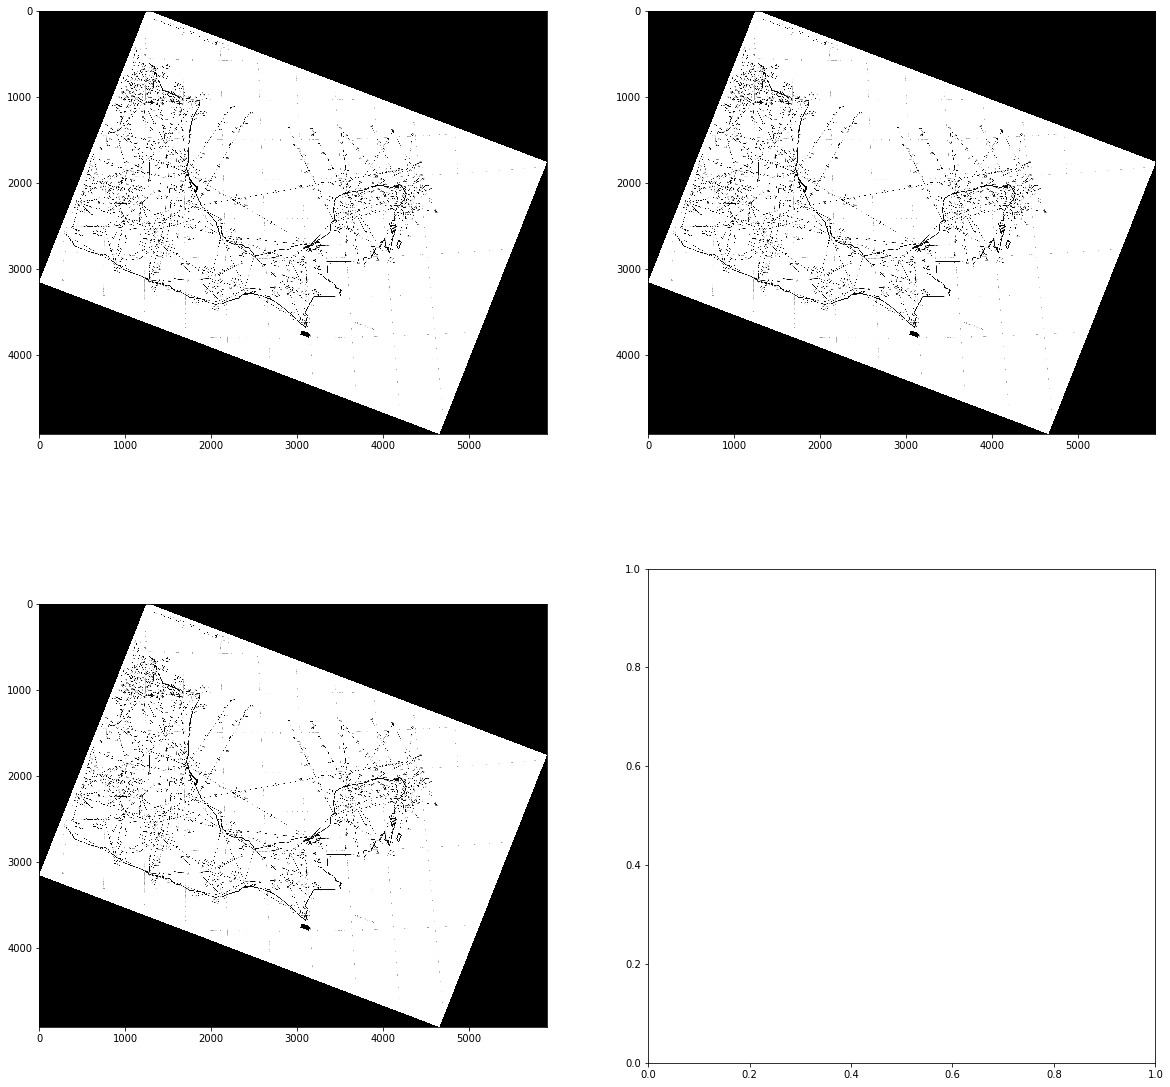

In [4]:
fig, axes = plt.subplots(2,2,figsize=(20,20))
axes = axes.reshape(-1,)
for ax, matr in zip(axes, matrs):
    ax.imshow(matr, plt.cm.Greys_r)
fig.show()

In [5]:
cconv = ConvCordinates(imgtif)
limsx, limsy = cconv.band_limits()
print(limsx + limsy)
shapedict = open_shape(zippedfile="Data/HYS20120420.zip")
# graph_shape(shapedict["GIS_06705_22178_06"]["coords"])
# shapedict["GIS_06705_22178_06"]["coords"]

[-105.36490815635833, -79.67175123615498, 30.447847585714538, 9.017290330801657]


In [6]:
pointImag = []
for point in shapedict["GIS_06705_22178_08"]["coords"][0]:
    pixx, pixy, sliced, array = cconv.locationpoint(imgtif.GetRasterBand(1), 
                                                    limsx + limsy, 
                                                    point)
    # print(pixx, pixy)
    pointImag.append([pixx, pixy])

volcan = [-98.62253, 19.02364] # punto del Popocatepetl
vxx, vxy, sliced, array = cconv.locationpoint(imgtif.GetRasterBand(1), 
                                                    limsx + limsy, 
                                                    volcan)
poly = np.array(pointImag)
# Para construir el poligono, cambia a renglones, columnas
rr, cc = polygon(poly[:, 1], poly[:, 0], array.shape)
imgshape = np.zeros((array.shape[0], array.shape[1]), dtype=np.uint8)
imgshape[rr, cc] = 1 * 255

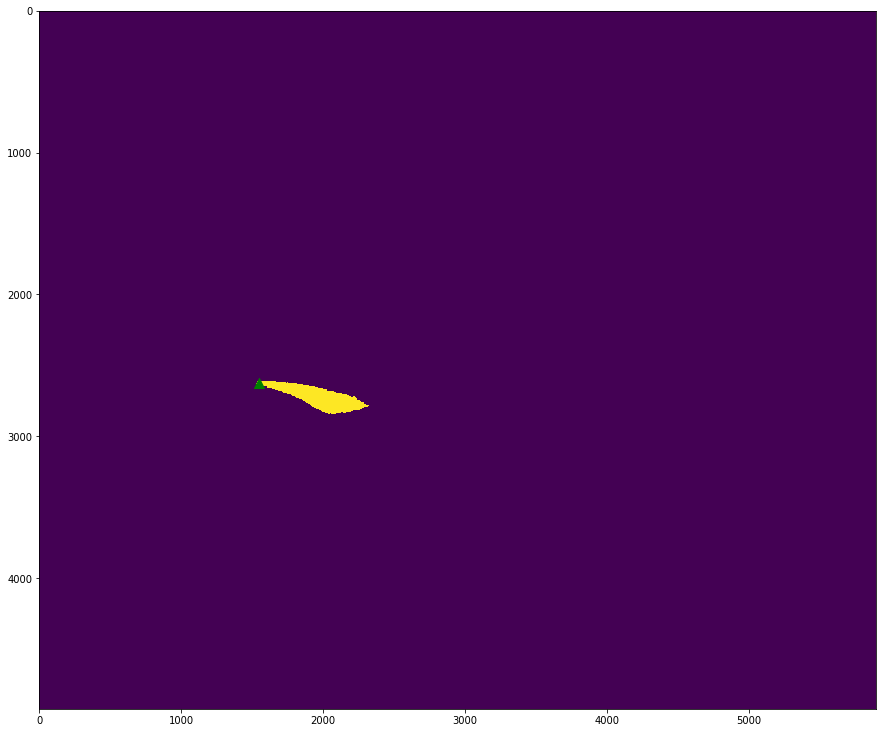

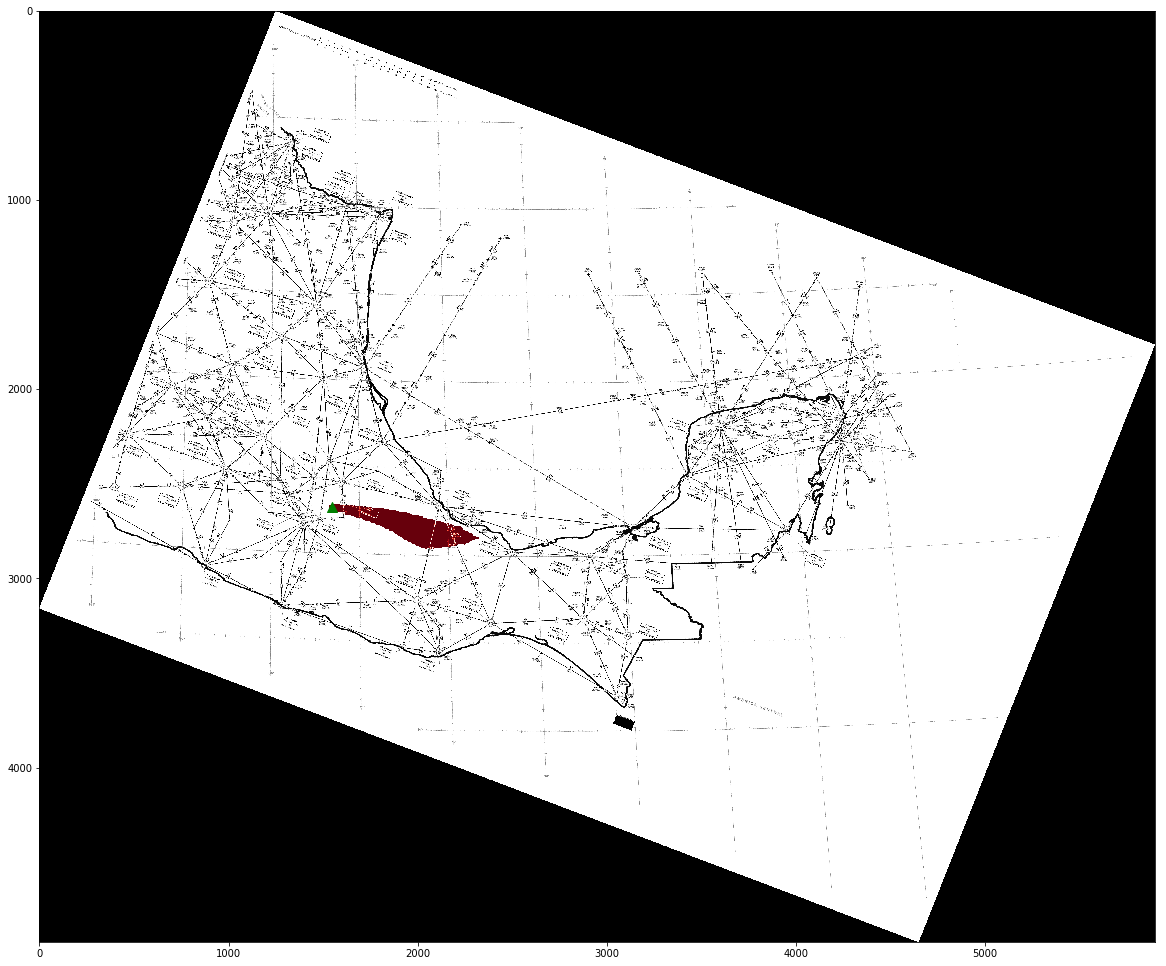

In [7]:
fig0 = plt.figure(figsize=(15,15))
ax0 = fig0.add_subplot(111)
ax0.scatter(x=vxx, y=vxy, s=100, c='green', marker="^")
ax0.imshow(imgshape)
fig0.show()

fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(111)
va = masked_array(array, imgshape)
vb = masked_array(array, np.logical_not(imgshape))
ax1.scatter(x=vxx, y=vxy, s=100, c='green', marker="^")
cm = ax1.imshow(va, cmap='gray')
ax1.imshow(vb, cmap='Reds')
fig1.show()